<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4). 

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.14.0
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
statsmodels 0.8.0
sklearn 0.19.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : c92a5f908fe34981eca12bed2d62691791bf6dfc


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)
res = cross_val_score(knn, X_train, y_train, cv=skf)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
round(np.mean(res),3), round(accuracy_score(knn.predict(X_valid), y_valid), 3)

(0.565, 0.584)

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [108]:
round(forest.oob_score_, 3), round(forest.score(X_valid, y_valid), 3)

(0.723, 0.735)

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [19]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [20]:
logit = LogisticRegression(random_state=17)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
logit_cv = cross_val_score(logit, X_train, y_train, cv=skf)

In [23]:
np.mean(logit_cv)

0.7610267543665875

In [24]:
accuracy_score(logit.predict(X_valid), y_valid)

0.7817018250770325

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [25]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 1.76 s, sys: 228 ms, total: 1.98 s
Wall time: 13.5 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [26]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[1], axis = 0)

In [27]:
logit_mean_cv_scores1

array([0.31822225, 0.47337913, 0.55273512, 0.65119285, 0.71297117,
       0.75137565, 0.75919878, 0.75676326, 0.74985389, 0.74050559])

In [28]:
logit_c_values1

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [29]:
logit_grid_searcher1.C_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [30]:
# C = 1.0, score = 0.75919878

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

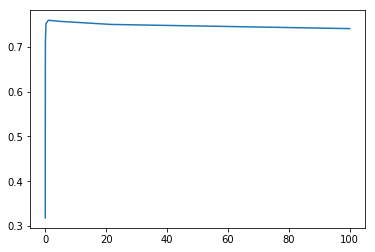

In [31]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [32]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.77 s, sys: 270 ms, total: 2.04 s
Wall time: 35.9 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [33]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[1], axis = 0)

In [34]:
logit_mean_cv_scores2

array([0.7354267 , 0.75889304, 0.75838615, 0.75767464, 0.75818317,
       0.75767572, 0.75798088, 0.75737171, 0.75686436, 0.75686494,
       0.75716964, 0.75656013, 0.75584927, 0.75544311, 0.75524069,
       0.75473337, 0.75483527, 0.75463214, 0.75432773, 0.75381935])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [35]:
logit_c_values2

array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])

In [36]:
best_C = logit_grid_searcher2.C_[0]

In [37]:
best_C

0.4631578947368421

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

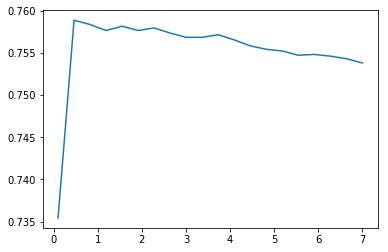

In [38]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [39]:
logit_cv_acc = accuracy_score(logit_grid_searcher2.predict(X_valid), y_valid)

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [40]:
round(logit_mean_cv_scores2[1], 3), round(logit_cv_acc, 3)

(0.759, 0.775)

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [41]:
from sklearn.svm import LinearSVC

In [42]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

In [43]:
svm_cv = cross_val_score(svm, X_train, y_train, cv=skf)

In [44]:
np.mean(svm_cv)

0.7526960152920014

In [45]:
accuracy_score(svm.predict(X_valid), y_valid)

0.7769613652524295

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [47]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv=skf, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.17 s, sys: 55.5 ms, total: 3.23 s
Wall time: 21 s


In [48]:
svm_params1

{'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
        4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
        8.8888889e+03, 1.0000000e+04])}

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [49]:
svm_grid_searcher1.best_params_, svm_grid_searcher1.best_score_

({'C': 6666.666700000001}, 0.6842105263157895)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

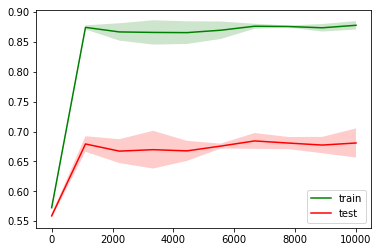

In [50]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [52]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 776 ms, sys: 72.7 ms, total: 849 ms
Wall time: 27.7 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [53]:
svm_grid_searcher2.best_params_, svm_grid_searcher2.best_score_

({'C': 0.10434482758620689}, 0.764681975208291)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

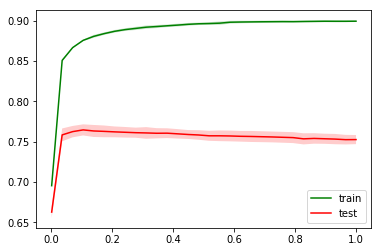

In [54]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [55]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.predict(X_valid), y_valid)

In [56]:
svm_cv_acc

0.7807537331121118

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [57]:
round(svm_grid_searcher2.best_score_, 3), round(svm_cv_acc, 3)

(0.765, 0.781)

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [58]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_file:
        X = pickle.load(X_file)
    with open(path_to_y_pickle, 'rb') as y_file:
        y = pickle.load(y_file)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size,
                                                          random_state=random_state,
                                                          stratify=y)
    cv_score = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    accuracy = accuracy_score(estimator.fit(X_train, y_train).predict(X_valid), y_valid)
    return np.mean(cv_score), accuracy

**Убедитесь, что функция работает.**

In [59]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7646853244550981, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [60]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [61]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        cv_score, val_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
        print('session_length: {}, window_size: {}, cv_score: {}, val_score: {}'.format(session_length,
                                                                                       window_size, cv_score, val_score))

session_length: 15, window_size: 10, cv_score: 0.8238214955278105, val_score: 0.8404835269021095
session_length: 10, window_size: 10, cv_score: 0.7646853244550981, val_score: 0.7807537331121118
session_length: 15, window_size: 7, cv_score: 0.8479403769844098, val_score: 0.8543222166915547
session_length: 10, window_size: 7, cv_score: 0.7970161463734652, val_score: 0.8073668491786958
session_length: 7, window_size: 7, cv_score: 0.7529891114830342, val_score: 0.7617388418782147
session_length: 15, window_size: 5, cv_score: 0.868001372554347, val_score: 0.8752963489805595
session_length: 10, window_size: 5, cv_score: 0.8159247205318039, val_score: 0.8245614035087719
session_length: 7, window_size: 5, cv_score: 0.774058674563226, val_score: 0.7853247984826932
session_length: 5, window_size: 5, cv_score: 0.7252830650398828, val_score: 0.7362494073020389
CPU times: user 9.57 s, sys: 350 ms, total: 9.92 s
Wall time: 17.6 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [62]:
#session_length: 15, window_size: 5, cv_score: 0.868001372554347, val_score: 0.8752963489805595
#POSCHITANO LIKE A BOSS
# больше примеров - лучше результат

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [63]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    cv_score, val_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)
    print('session_length: {}, window_size: {}, cv_score: {}, val_score: {}'.format(session_length,
                                                                                       window_size, cv_score, val_score))

session_length: 5, window_size: 5, cv_score: 0.40858659509908596, val_score: 0.42171606560568453
session_length: 7, window_size: 7, cv_score: 0.43638649409423974, val_score: 0.45295840855673264
session_length: 10, window_size: 10, cv_score: 0.4612588999427913, val_score: 0.4836276942538802
CPU times: user 6min 15s, sys: 1.44 s, total: 6min 17s
Wall time: 11min 23s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [64]:
%%time
estimator = svm_grid_searcher2.best_estimator_
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl')
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users.pkl')
cv_score, val_score = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)

CPU times: user 1min 58s, sys: 171 ms, total: 1min 58s
Wall time: 3min 41s


In [65]:
round(cv_score, 3), round(val_score, 3)

(0.461, 0.484)

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [66]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [67]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [94]:
%%time
Cs=[0.4631578947368421]
logit_cv_150users = LogisticRegressionCV(Cs=Cs, cv=skf, multi_class='ovr', n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 3min 30s, sys: 20.5 s, total: 3min 50s
Wall time: 6min 32s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [95]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 1, CV score: 0.9958396485310578
User 2, CV score: 0.996236159606072
User 3, CV score: 0.9951414156621485
User 4, CV score: 0.9917629636028263
User 5, CV score: 0.990032646749408
User 6, CV score: 0.9945992933895361
User 7, CV score: 0.9936295923347456
User 8, CV score: 0.9857474441964414
User 9, CV score: 0.9979773735144889
User 10, CV score: 0.9949328849394247
User 11, CV score: 0.9944847392709221
User 12, CV score: 0.9936087227963695
User 13, CV score: 0.9969973347781819
User 14, CV score: 0.9949640742212859
User 15, CV score: 0.9963612639936241
User 16, CV score: 0.9963196987839488
User 17, CV score: 0.9905122649916512
User 18, CV score: 0.9943596252032839
User 19, CV score: 0.9947138940123931
User 20, CV score: 0.991190153815365
User 21, CV score: 0.9798572049408728
User 22, CV score: 0.9968201105460203
User 23, CV score: 0.9945051894225921
User 24, CV score: 0.9906581115547454
User 25, CV score: 0.9966011573912393
User 26, CV score: 0.9942028893690901
User 27, CV score: 0.994

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [96]:
class_distr = np.bincount(y_train_150.astype('int'))

acc_diff_vs_constant = [cv_scores_by_user[user_id] - (1 - class_distr[user_id]/y_train_150.shape[0]) for user_id in np.unique(y_train_150)]
    

In [102]:
class_distr

array([   0, 1496,  412,  537, 1466, 1156,  532,  715, 1543,  276,  592,
        561,  763,  295,  493,  350,  365,  952,  561,  504,  917, 2206,
        382, 1226,  959,  389,  608,  570, 1198, 1957,  277,  309,  332,
        280,  359,  336,  366, 1308,  339,  361,  312, 1076, 1150,  358,
        405,  374,  512,  406,  276,  470,  355,  967,  426,  407,  462,
        280, 1045,  806,  364, 1367, 1427,  601, 1128,  388,  981,  434,
        482,  277,  447,  323,  305,  482,  391,  335,  776,  309,  860,
        267,  323,  451, 1033,  323,  560,  456,  273,  478,  279,  286,
       1152,  371,  456,  577,  706, 1825,  354,  467,  784, 1434,  412,
        867, 1093,  538, 1872, 3257, 2068,  902,  474,  473,  284,  382,
        264,  520,  319,  393,  300,  456,  366,  612,  397,  309,  450,
        406,  484,  284,  459, 1007,  291,  296,  309,  946, 1141,  913,
        404,  463,  350,  256,  288,  304, 1081,  792,  438,  391,  351,
        446,  496,  246, 1205,  727,  354,  435,  4

In [97]:
num_better_than_default = (np.array(acc_diff_vs_constant) > 0).sum()

In [99]:
num_better_than_default

137

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [109]:
num_better_than_default / 151

0.9072847682119205

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = #VASH KOD ZDES

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.